# This script contains code to plot Figure 4
# Also contains some of the analysis for the SI
### Created by Alon Bar at Uri Alon's Lab for system biology, Weizmann institute

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import calendar
import pickle
import os
import scipy.io as sio
import matplotlib.image as mpimg
import json
from scipy.integrate import odeint
from matplotlib import ticker
from tqdm import tqdm_notebook as tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import circmean,circstd
from scipy.optimize import curve_fit
from scipy.stats import zscore
from sympy import *
from datetime import datetime
import pingouin as pg
import seaborn as sns
from sklearn.linear_model import LinearRegression
import random

def_color=plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'size'   : 15}
month_names   = [x[:3] for x in calendar.month_name[1:13]]
month_names0  = np.roll(month_names,1)
slow_rate     = np.log(2)/30
K0            = 4
seasons       = ['Spring','Summer','Autumn','Winter']

# Simulated equations

In [2]:
def daylen(phi,delta=23.44*np.pi/180):#23.44 degrees is earth tilt
    '''Computes fractional change in daylength as function of latitude'''
    return (2*(180/np.pi*np.arccos(np.tan(delta)*np.tan(phi*np.pi/180)))/15)

def GR_Resistance_fast(y,uapkr):
    ## timescale of minutes
    a1=0.17 #[1/min]
    a2=0.035 #[1/min]
    a3=0.0091 #[1/min]
    b1=a1;b2=a2;b3=a3

    u,A,P,k,R = uapkr
    [x1,x2,x3] = y 
    dy         = np.empty(3)
    
    dy[0] = u*b1/(x3*(1+(x3/k)**3))-a1*x1
    dy[1] = b2*x1*P/(1+(x3/k)**3)  -a2*x2
    dy[2] = b3*x2*A                -a3*x3/R
    return dy

def GetNumericSS_GR(U,A,P,K,R):
    t      = np.linspace(0,60*24,100)
    sol    = odeint(lambda y,t:GR_Resistance_fast(y,[U,A,P,K,R]),[1,1,1],t)
    res = sol[-1,:]
    return res

def simple_fast(y,uapk):
    ## timescale of minutes
    a1=0.17 #[1/min]
    a2=0.035 #[1/min]
    a3=0.0091 #[1/min]
    b1=a1;b2=a2;b3=a3

    u,A,P,k  = uapk
    [x1,x2,x3] = y 
    dy         = np.empty(3)

    dy[0] = u*b1/x3-a1*x1
    dy[1] = b2*x1*P-a2*x2
    dy[2] = b3*x2*A-a3*x3/R
    return dy

def GetNumericSS_simple(U,A,P,K):
    t      = np.linspace(0,60*24,100)
    sol    = odeint(lambda y,t:simple_fast(y,[U,A,P,K]),[1,1,1],t)
    res = sol[-1,:]
    return res

# Figure S9

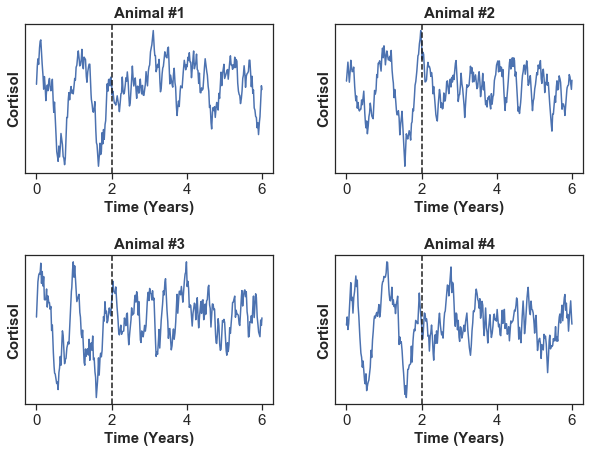

In [3]:
noise_strangth = 0.5
x3_noise       = []
for repeats in range(4):
    sim_time = np.linspace(0,365*6,365*6)
    b        = noise_strangth
    a        =-noise_strangth
    noise    = (b-a)*np.random.random(len(sim_time)*2) + a
    
    def noisy_input(t):
        floor=int(np.floor(t))
        ceil =floor+1
        return noise[ceil]*(t-floor)+noise[floor]*(ceil-t)

    slow_rate  = np.log(2)/30
    K0         = 4
    adrenal    = np.zeros_like(sim_time)
    pituitary  = np.zeros_like(sim_time)
    adrenal[0] = 1; pituitary[0] = 1 
    aP=slow_rate; aA=slow_rate; 
    bP=slow_rate; bA=slow_rate

    for i,t in enumerate(sim_time[:-1]): 
        A = adrenal[i]; P = pituitary[i]

        #noise vary weekly
        if t<2*365:
            u  = 1 + 0.5*(1 - daylen(50,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12) + noisy_input(np.floor(t/7))
        else:
            u  = 1 + noisy_input(np.floor(t/7))

        x1,x2,x3 = GetNumericSS_GR(u,A,P,K0,1)
        dA = A*(bA*x2-aA)
        dP = P*(bP*x1-aP) 
        adrenal[i+1]   = A + dA
        pituitary[i+1] = P + dP

    res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal,pituitary)])
    res = res
    x3  = res[:,2]
    x3_noise.append(x3)

slow_rate   = np.log(2)/30
K0          = 4
adrenal_    = np.zeros_like(sim_time)
pituitary_  = np.zeros_like(sim_time)
adrenal_[0] = 1; pituitary_[0] = 1; 
aP=slow_rate; aA=slow_rate; 
bP=slow_rate; bA=slow_rate

for i,t in enumerate(sim_time[:-1]): 
    A = adrenal_[i]; P = pituitary_[i]

    u = 1 + 0.5*(1 - daylen(50,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12) 

    x1,x2,x3_   = GetNumericSS_GR(u,A,P,K0,1)
    dA = A*(bA*x2-aA)
    dP = P*(bP*x1-aP) 
    adrenal_[i+1]   = A + dA
    pituitary_[i+1] = P + dP

res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal_,pituitary_)])
res = res
x3_seasonal = res[:,2]
    
plt.figure(figsize=(10,7))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.plot(sim_time/365,x3_noise[i],c=def_color[0])
    ax.set_xlabel('Time (Years)',fontsize=15,fontweight='bold')
    ax.set_ylabel('Cortisol',fontsize=15,fontweight='bold')
    ax.tick_params(axis='x',labelsize =15)
    ax.set_yticks([])    
    ax.axvline(2,ls='--',color='k')
    ax.set_title('Animal #' + str(i+1),fontsize=15,fontweight='bold')
plt.subplots_adjust(hspace=0.55,wspace=0.25)
# plt.savefig('../figures/Seasonality160620/SI_noise_driven_.pdf',bbox_inches='tight',dpi=600)
plt.show()

In [4]:
def get_abs_amp(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,1]
    return np.mean(v),np.std(v)

def get_phase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,2]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_abs_amp2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the amplitude
    '''
    v=boots_mat[:,3]
    return np.mean(v),np.std(v)

def get_phase2(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,4]
    return circmean(v,high=np.pi, low=-np.pi),circstd(v,high=np.pi, low=-np.pi)

def get_acrophase(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,5]
    
    return circmean(v,high=12, low=0),circstd(v,high=12, low=0)

def get_relmaxmin(boots_mat):
    '''
    Input is bootstrp result (output of bootstrap_months_cosinor method)
    Output is the mean and std of the phase 
    '''
    v=boots_mat[:,6]
    return np.mean(v),np.std(v)

def seasonal_age_process(hormone,sex,dtype='raw'):
    file    = '../data/Clalit_seasonality_Nov19/age.' + hormone +'.healthy_no_meds.' + dtype + '.with_infection.0.05.20_30_40_50_60_70_80.csv'
    df = pd.read_csv(file)
    
    df = df.loc[df['type'] != 'both']
    if sex != 'both':
        df = df.loc[df['type'] == sex]
    
    df.loc[df['month'] == 12,['month']] = 0
    
    month_pooled_mean = []
    month_pooled_std  = []
    month_pooled_n    = []

    for month in np.arange(0,12):
        mdf = df.loc[df.month==month]
        month_pooled_mean.append(np.sum(mdf['mean']*mdf['n'])/np.sum(mdf['n']))
        month_pooled_std.append(np.sqrt(np.sum(mdf['std']**2*(mdf['n']-1))/(np.sum(mdf['n']) - len(mdf))))
        month_pooled_n.append(np.sum(mdf['n']))

    both_res = pd.DataFrame({'month': np.arange(0,12),
                             'mean' : month_pooled_mean,
                             'std'  : month_pooled_std,
                             'n'    : month_pooled_n})
    return both_res

def data2xy(data):
    '''
    Take a seasonality data from a file and change the months to angle (0,2*pi)
    return the angle month and the mean for each month
    '''
    xdat=2*np.pi*(np.arange(12)/12+25/365)#month
    ydat=np.array(data['mean'])#hormone value
    edat= np.array(data['std']/np.sqrt(data['n']))
    return xdat,ydat,edat

        
def fit_cosinor(xdat,ydat):
    '''
    compute the cosinor fit of data M+A*cos(w*t+phi),as well as the max-min of the data
    return the result as a vector
    the input should be after rescaling using data2xy function
    The fit is for x0 = December (assume 15/12, mid December) 
    '''    
    M       = np.mean(ydat)
    ydat    = ydat-M
    st      = np.std(ydat)
    maxamp  = np.max(abs(ydat))
    
    rel_maxmin= (np.max(ydat)-np.min(ydat))/2
    acrophase = ydat.argmax()

    res_fit, pcov = curve_fit(lambda x,A,phi: A*np.cos(x+phi),
                              xdat,
                              ydat,
                              p0=[st,0],
                              bounds=[(maxamp/20,-np.pi),(maxamp,np.pi)])
    A11         = res_fit[0]
    phi11       = res_fit[1]
    first_order = np.array([M,A11,phi11,0,0,acrophase,rel_maxmin])
    res_fit, pcov = curve_fit(lambda x,A1,phi1,A2,phi2: A1*np.cos(x+phi1) + A2*np.cos(2*x+phi2),
                              xdat,
                              ydat,
                              p0=[st,0,st,0],
                              bounds=[(maxamp/20,-np.pi,maxamp/20,-np.pi),(maxamp,np.pi,maxamp,np.pi)])
    
    A21         = res_fit[0]
    phi21       = res_fit[1]
    A22         = res_fit[2]
    phi22       = res_fit[3]
    second_order = np.array([M,A21,phi21,A22,phi22,acrophase,rel_maxmin])
    return first_order,second_order

def bootstrap_months_cosinor(data,nboots=500):
    '''
    Apply bootstrapping, sampling random months from the data
    fit cosinor to each sample to obtain mean and std for the cosinor values
    '''
    # get data
    xdat,ydat,edat = data2xy(data)
    
    params=np.zeros([nboots,7])
    params2=np.zeros([nboots,7])

    #bootstrap data and fit first and second order cosinor to each iteration
    #bootsrap by randomly samlping each month from its errorbar (normal disturbiotion)
    for i in range(nboots):
        yboot = [np.random.normal(loc = y,scale = e) for y,e in zip(ydat,edat)]
        params[i,:],params2[i,:] = fit_cosinor(xdat,yboot)

    # avarage bootstrap to get cosinor parameters 
    cosinor_tables = []   
    for pars in [params,params2]:
        
        all_tests_phase     = []
        all_tests_phase2    = []
        all_tests_amp       = []
        all_tests_amp2      = []
        all_tests_acrophase = []
        all_tests_relmaxmin = []
        all_tests_phase      .append(get_phase(pars))
        all_tests_phase2     .append(get_phase2(pars))
        all_tests_amp        .append(get_abs_amp(pars))
        all_tests_amp2       .append(get_abs_amp2(pars))
        all_tests_acrophase  .append(get_acrophase(pars))
        all_tests_relmaxmin  .append(get_relmaxmin(pars))
        
        # normalize phase back to months
        phase_mean       = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase]
        phase_std        = [12/(2*np.pi)*x[1] for x in all_tests_phase]
        all_tests_phase  = [(phase_mean[i],phase_std[i]) for i in range(len(phase_mean))] 

        phase_mean2      = [np.mod(12/(2*np.pi)*(-x[0]),12) for x in all_tests_phase2]
        phase_std2       = [12/(2*np.pi)*x[1] for x in all_tests_phase2]
        all_tests_phase2 = [(phase_mean2[i],phase_std2[i]) for i in range(len(phase_mean2))] 
     
        all_tests_phase  = np.array(all_tests_phase).flat[:]
        all_tests_phase2 = np.array(all_tests_phase2).flat[:]
        all_tests_amp    = np.array(all_tests_amp).flat[:]
        all_tests_amp2   = np.array(all_tests_amp2).flat[:]
        all_tests_acrophase = np.array(all_tests_acrophase).flat[:]
        all_tests_relmaxmin = np.array(all_tests_relmaxmin).flat[:]
        cosinor_tables.append(np.array([all_tests_amp,all_tests_phase,all_tests_amp2,all_tests_phase2,all_tests_acrophase,all_tests_relmaxmin]))

    # calculate akaika infromation coeff and choose better fit as cosinor for lab test   
    aic1,aic2,aic_null = cosinors_aic(xdat,ydat,edat,cosinor_tables)
    
    best_model = np.argmin(np.array([aic1,aic2,aic_null]))
        
    if best_model   == 0:
        return cosinor_tables[0]
    elif best_model == 1:
        return cosinor_tables[1]
    else:
        return np.zeros_like(cosinor_tables[0])
    
def cosinors_aic(xdat,ydat,edat,cosinor_tables):        
    M          = np.mean(ydat)
    n          = len(ydat)
        
    # first order
    amp        = cosinor_tables[0][0][0]
    phase      = cosinor_tables[0][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 2
    aic1       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365))
    
    # seconde order
    amp        = cosinor_tables[1][0][0]
    phase      = cosinor_tables[1][1][0]
    p          = (phase/12)*2*np.pi - 2*np.pi/12
    amp2       = cosinor_tables[1][2][0]
    phase2     = cosinor_tables[1][3][0]
    p2         = (phase2/12)*2*np.pi - 2*np.pi/12
    
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
    residuals  = ydat - cosine
    ss_res     = np.sum(residuals**2)
    k          = 4
    aic2       = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    cosine     = M + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/365)) + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/365))
    
    ## null model
    residuals  = ydat - M # constant with mean = 0 
    ss_res     = np.sum(residuals**2)
    k          = 0
    aic_null   = 2*k + n*log(ss_res/n) + 2*k*(k+1)/(n-k-1)
    return aic1,aic2,aic_null   

def get_cosinor(hormone,sex,dtype='raw'):
    dat           = seasonal_age_process(hormone,sex,dtype = dtype)
    cosinor_table = bootstrap_months_cosinor(dat)
    return cosinor_table

def gen_hormone_list(hormone_dic,datatype='raw'):
    hormone_list = {}
    for j,k in tqdm(enumerate(hormone_dic.keys())):
        sex_list = {}
        for i,sex in enumerate(['female','male','both']):

            hormone = seasonal_age_process(k,sex,dtype = datatype)
            xloc = hormone['month'].values
            yloc = hormone['mean'].values
            err  = hormone['std']/hormone['n']**0.5
            ntot = np.sum(hormone['n'])

            hormone_table = get_cosinor(k,sex,dtype = datatype)
            amp           = hormone_table[0][0]
            amp_std       = hormone_table[0][1]
            phase         = hormone_table[1][0] - 1
            phase_std     = hormone_table[1][1]
            amp2          = hormone_table[2][0]
            amp_std2      = hormone_table[2][1]
            phase2        = hormone_table[3][0] - 1
            phase_std2    = hormone_table[3][1]
            acrophase     = hormone_table[4][0] 
            acrophase_std = hormone_table[4][1]
            maxmin        = hormone_table[5][0]
            maxmin_std    = hormone_table[5][1]
            
            p           = (phase/12)*2*np.pi
            p2          = (phase2/12)*2*np.pi
            cosine      = np.mean(yloc) + amp*np.cos(np.arange(-p,2*np.pi-p,2*np.pi/12))
            cosine2     = cosine + amp2*np.cos(np.arange(-p2,4*np.pi-p2,4*np.pi/12))
            seasonal_data = {'Clalit'  :{'xloc':xloc,'yloc':yloc,'err':err,'ntot':ntot},
                             'Cosinor' :{'pars':[[phase,amp,acrophase,maxmin],[phase_std,amp_std,acrophase_std,maxmin_std]],'cosine':cosine},
                             'Cosinor2':{'pars':[[phase2,amp2,acrophase,maxmin],[phase_std2,amp_std2,acrophase_std,maxmin_std]],'cosine':cosine2}}

            sex_list.update({sex:seasonal_data})
        hormone_list.update({hormone_dic[k]:sex_list})  
    return hormone_list

def bootstrap_maxmin12(data,nboots=500):
    params=np.zeros(nboots)
    for i in range(nboots):
        inds=np.random.randint(0,12,12)
        rand_dat=data[inds]
        params[i]=(max(rand_dat)-min(rand_dat))/(2*np.mean(rand_dat))
    return np.mean(params),np.std(params)

def bootstrap_maxmin8(data,nboots=500):
    params=np.zeros(nboots)
    for i in range(nboots):
        inds=np.random.randint(0,8,8)
        rand_dat=data[inds]
        params[i]=(max(rand_dat)-min(rand_dat))/(2*np.mean(rand_dat)) 
    return np.mean(params),np.std(params)

In [5]:
Cortisol_Raw_fit  = gen_hormone_list({'CORTISOL_U_FREE_24h':'Cortisol-24h',
                                      'CORTISOL_BLOOD'     :'Cortisol'})
table = []
for key in ['Cortisol','Cortisol-24h']:
    for sex in ['female','male','both']:
        table.append([key] + [sex] + [Cortisol_Raw_fit[key][sex]['Clalit']['ntot']] + [Cortisol_Raw_fit[key][sex]['Clalit']['yloc'].mean()] + [Cortisol_Raw_fit[key][sex]['Clalit']['err'].mean()] + Cortisol_Raw_fit[key][sex]['Cosinor']['pars'][0] + Cortisol_Raw_fit[key][sex]['Cosinor2']['pars'][0] + Cortisol_Raw_fit[key][sex]['Cosinor']['pars'][1] + Cortisol_Raw_fit[key][sex]['Cosinor2']['pars'][1])
table = np.array(table)
df    = pd.DataFrame(table,columns = ['hormone','sex','n','M','Merr','phase','amp','acrophase','maxmin','phase2','amp2','acrophase2','maxmin2','phase_std','amp_std','acrophase_std','maxmin_std','phase2_std','amp2_std','acrophase2_std','maxmin2_std'])

df = df.drop(columns = ['acrophase2','maxmin2','Merr'])
df[df.columns[3:]] = df[df.columns[3:]].astype(float)
print('Table S1')
# display(df[['hormone','sex','n','M','Merr','phase','phase_std','amp','amp_std','phase2','phase2_std','amp2','amp2_std','maxmin','maxmin_std','acrophase','acrophase_std']])
df_array = df[df.columns[3:]].values 

df_array[df_array>0.00000001] = np.round(df_array[df_array>0.00000001],decimals=9)
df_array[df_array>0.0000001] = np.round(df_array[df_array>0.0000001],decimals=8)
df_array[df_array>0.000001] = np.round(df_array[df_array>0.000001],decimals=7)
df_array[df_array>0.00001] = np.round(df_array[df_array>0.00001],decimals=6)
df_array[df_array>0.0001] = np.round(df_array[df_array>0.0001],decimals=5)
df_array[df_array>0.001] = np.round(df_array[df_array>0.001],decimals=4)
df_array[df_array>0.01] = np.round(df_array[df_array>0.01],decimals=3)
df_array[df_array>0.1] = np.round(df_array[df_array>0.1],decimals=2)

df[df.columns[3:]]  = df_array
df['phase_str']     = [str(df.iloc[i]['phase']) +'±' + str(df.iloc[i]['phase_std']) for i in range(len(df))]
df['amp_str']       = [str(df.iloc[i]['amp']) +'±' + str(df.iloc[i]['amp_std']) for i in range(len(df))]
df['acrophase_str'] = [str(df.iloc[i]['acrophase']) +'±' + str(df.iloc[i]['acrophase_std']) for i in range(len(df))]
df['maxmin_str']    = [str(df.iloc[i]['maxmin']) +'±' + str(df.iloc[i]['maxmin_std']) for i in range(len(df))]
df['phase2_str']    = [str(df.iloc[i]['phase2']) +'±' + str(df.iloc[i]['phase2_std']) for i in range(len(df))]
df['amp2_str']      = [str(df.iloc[i]['amp2']) +'±' + str(df.iloc[i]['amp2_std']) for i in range(len(df))]

display(df[['hormone','sex','M','phase_str','amp_str','acrophase_str','maxmin_str','phase2_str','amp2_str']])
isr_df = df.copy()


Table S1


,hormone,sex,M,phase_str,amp_str,acrophase_str,maxmin_str,phase2_str,amp2_str
0,Cortisol,female,446.02,3.45±0.17,8.72±0.87,3.22±0.98,12.76±1.22,4.8±0.29,5.4±0.8
1,Cortisol,male,418.60,2.95±0.49,5.21±1.25,1.46±1.04,10.29±1.7,-1.0±-0.0,0.0±0.0
2,Cortisol,both,439.13,3.39±0.17,7.67±0.68,2.7±0.96,11.09±1.0,4.71±0.27,4.93±0.67
3,Cortisol-24h,female,154.13,1.43±0.38,5.8±1.0,1.69±0.72,8.58±1.47,-1.0±-0.0,0.0±0.0
4,Cortisol-24h,male,208.43,-1.0±0.0,0.0±0.0,0.0±0.0,0.0±0.0,-1.0±0.0,0.0±0.0
5,Cortisol-24h,both,170.32,1.18±0.33,5.93±1.02,1.08±0.48,9.44±1.48,-1.0±-0.0,0.0±0.0


# Calulate model's cortisol amplitude by latitude 

In [6]:
# K0      = 4
# k       = 70
# PHIs    = np.arange(20,k,1)
# amp_res = []
# for phi in tqdm(PHIs):
#     sim_time   = np.linspace(-21,3*365-1-21,3*365)
#     adrenal    = np.zeros_like(sim_time)
#     pituitary  = np.zeros_like(sim_time)

#     adrenal[0] = 1; pituitary[0] = 1; 
#     aP=slow_rate; aA=slow_rate; 
#     bP=slow_rate; bA=slow_rate

#     for i,t in enumerate(sim_time[:-1]): 
#         A = adrenal[i]; P = pituitary[i]
#         u          = 1 + 0.5*(1 - daylen(phi,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12)
#         x1,x2,x3   = GetNumericSS_GR(u,A,P,K0,1)
#         dA = A*(bA*x2-aA) #Adrenal cells
#         dP = P*(bP*x1-aP) #Pituitary cells
#         adrenal[i+1]   = A + dA
#         pituitary[i+1] = P + dP

#     adrenal   = adrenal[-365:] ; pituitary = pituitary[-365:]
#     res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal,pituitary)])
#     res = res/np.mean(res,axis=0)
#     x3  = res[:,2]
#     amp_res.append((x3.max()-x3.min())/(2*x3.mean()))
# pickle.dump([PHIs,amp_res],open('../data/Theoretical_amplitude_latitude.pickle','wb'))

# Plotting functions

In [7]:
def theory_3_subplot(axes,time, day_length, data1, data2, label1, label2, color1, color2):
    '''
    This function is used to plot effector and pituitary hormone together on a graph with two y-axes
    '''
    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    
    ln1=ax1.plot(time,day_length,color=def_color[7],linewidth=3.0)
    ln2=ax2.plot(time,data1,linestyle='-',color=color1,linewidth=3.0)
    ln3=ax3.plot(time,data2,linestyle='-',color=color2,linewidth=3.0)
    
    ax1.tick_params(axis='y')
    ax1.set_ylabel('Day length [h]',fontsize=15,fontweight='bold')
    ax2.set_ylabel(label1,fontsize=15,fontweight='bold',color=color1)
    ax3.set_ylabel(label2,fontsize=15,fontweight='bold',color=color2)
    
    ax1.set_xlim([0,12])
    ax2.set_xlim([0,12])
    ax3.set_xlim([0,12])

    ax1.xaxis.set_visible(False)    
    ax2.xaxis.set_visible(False)    
    
    ax1.tick_params(axis='y',labelsize =15)
    ax1.set_yticks([]) 
    ax2.set_yticks([]) 
    ax3.set_yticks([]) 

    ax3.tick_params(axis='x',labelsize =15)
    
    
def HPA_graph1_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA1.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Constant \ngland mass'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.6),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')

    ax.annotate('Pituitary',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.5),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')
    
    ax.annotate('Adrenal',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.2),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

def HPA_graph2_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA2.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Gland mass \nnegative \nfeedback'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
    
    ax.annotate('Pituitary',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.5),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')
    
    ax.annotate('Adrenal',fontsize=14,fontweight='bold',color='k',
            xytext=(0.09,0.2),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')
    
def HPA_graph2b_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA2.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Gland mass \nnegative \nfeedback,' + '$K_GR$'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
    
def HPA_graph3_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA3.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Slow GR \nresistance'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.6),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
    
def HPA_graph4_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA4.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'Cortisol reduces \nits own \nremoval rate'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')

    
def HPA_graph5_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA5.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'u controlling \nGR resistance'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')
        
def HPA_graph6_above_axe(ax):
    import matplotlib.image as mpimg
    hpa1 = mpimg.imread('../figures/ppt/HPA6.PNG')
    ax.imshow(hpa1)
    ax.axis('off')
    notation = 'u controlling \ncortisol \nremoval rate'
    ax.annotate(notation,fontsize=18,fontweight='bold',
                xytext=(0.63,0.5),xy=(-0.96,0.2),
                xycoords='axes fraction',textcoords='axes fraction')

# Bootstrap data from cortisol seasonality studies to  get amplitude and error

In [8]:
def relmaxmin(A):
    return (A.max() - A.min())/(2*A.mean())

sweden_dat_30_min= np.array([16.3,16.85,15.15,16.8,14.2,10.4,12.85,12.2,14.2,14.2,13.7,16.3])
SWDamp,SWDerr    = bootstrap_maxmin12(sweden_dat_30_min,nboots=25000)
SWDraw_amp       = relmaxmin(sweden_dat_30_min)

uk_hair_dat      = np.array([4.21,3.26,2.78,3.25,3.42,3.49,3.83,3.86])
UKHamp,UKHerr    = bootstrap_maxmin8(uk_hair_dat,nboots=25000)
UKHraw_amp       = relmaxmin(uk_hair_dat)

cla_dat_24h      = Cortisol_Raw_fit['Cortisol-24h']['both']['Clalit']['yloc']
cla24amp,cla24err= bootstrap_maxmin12(cla_dat_24h,nboots=25000)
cla24raw_amp     = relmaxmin(cla_dat_24h)

cla_dat          = Cortisol_Raw_fit['Cortisol']['both']['Clalit']['yloc']
claamp,claerr    = bootstrap_maxmin12(cla_dat,nboots=25000)
claraw_amp       = relmaxmin(cla_dat)

latitude_df = pd.DataFrame()
latitude_df['countries']                  = ['Sweden','UK','Israel-urine','Israel']
latitude_df['Bootstrap relative max-min'] = [SWDamp,UKHamp,cla24amp,claamp]
latitude_df['Bootstrap error']            = [SWDerr,UKHerr,cla24err,claerr]
latitude_df

,countries,Bootstrap relative max-min,Bootstrap error
0,Sweden,0.196148,0.039633
1,UK,0.161593,0.041687
2,Israel-urine,0.044221,0.007665
3,Israel,0.022005,0.002616


In [9]:
def plot_latitudes(ax):
    import matplotlib.patheffects as path_effects

    ## australian datapoints where grabbed from Fig1 column 2 in the original Hadlow paper (2018) using grabbit via MATLAB
    AUSamp           = np.array([0.0345,0.0477,0.0564,0.0584])
    AUSerr           = np.array([5.38684342449727 - 3.19946527042832,
                                9.05950095969289 - 4.31642445845900,
                                13.9270679258164 - 10.7361474570486,
                                14.1162376016940 - 10.1989301237045])/100/2
    ISRamp           = np.array([claamp,cla24amp])
    ISRerr           = np.array([claerr,cla24err])

    df = pd.read_excel('../latitude_amplitude_table .xlsx',usecols=['Place','|latitude|','Mesurment'])
#     display(df)
    df['Relative max-min'] = np.concatenate((AUSamp.flat[:],SWDamp.flat[:],UKHamp.flat[:],ISRamp.flat[[1,0]]))
    df['error']            = np.concatenate((AUSerr.flat[:],SWDerr.flat[:],UKHerr.flat[:],ISRerr.flat[[1,0]]))
    
    df['marker'] = np.nan
    df.loc[df['Mesurment']=='serum'    ,['marker']] = '.'
    df.loc[df['Mesurment']=='hair'     ,['marker']] = 'o'
    df.loc[df['Mesurment']=='saliva'   ,['marker']] = '^'
    df.loc[df['Mesurment']=='24h-urine',['marker']] = 's'

    #  's'   # 
    ddf = df.loc[df['marker'] =='s']
    urine = ax.errorbar(ddf['|latitude|'].values,ddf['Relative max-min'].values,ddf['error'],
                marker='s',ls='none',markersize=8,color=def_color[0],mec='k',capthick=4,elinewidth=2)
    urine[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])
    
    #  '.'   # 
    ddf = df.loc[df['marker'] =='o']
    hair = ax.errorbar(ddf['|latitude|'].values,ddf['Relative max-min'].values,ddf['error'],
                marker='o',ls='none',markersize=8,color=def_color[0],mec='k',capthick=4,elinewidth=2)
    hair[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])
    
    #  'o'   # 
    ddf = df.loc[df['marker'] =='.']
    serum = ax.errorbar(ddf['|latitude|'].values,ddf['Relative max-min'].values,ddf['error'],
                marker='o',ls='none',markersize=8,color=def_color[0],mec='k',capthick=4,elinewidth=2)
    serum[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])

    serum = ax.errorbar(ddf['|latitude|'].values,ddf['Relative max-min'].values,ddf['error'],
                marker='.',ls='none',markersize=8,color='white',ecolor=def_color[0],mec='k',capthick=4,elinewidth=2)
    serum[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])
    
    #  '^'   # 
    ddf = df.loc[df['marker'] =='^']
    saliva = ax.errorbar(ddf['|latitude|'].values,ddf['Relative max-min'].values,ddf['error'],
                marker='^',ls='none',markersize=8,color=def_color[0],mec='k',capthick=4,elinewidth=2)
    saliva[2][0].set_path_effects([path_effects.Stroke(linewidth=4, foreground='black'),path_effects.Normal()])
    

    ax.set_xlabel('|latitude|',fontsize=15,fontweight='bold')
    ax.set_ylabel('Relative max-min amplitude',fontsize=15,fontweight='bold')
    
    locs =[[-4,-0.035],[-4,0.03],[-1,0.025],[1,-0.03],[0.5,0.02],[1,0],[-6.5,0.01],[-0.5,-0.025]]
    for i,place in enumerate(df['Place']):
        if 'Aus' in place:
            place = place.replace('Australia','Aus')
        place = place.replace(',','\n')
        ax.annotate(place, (np.abs(df['|latitude|'].values)[i]+locs[i][0], df['Relative max-min'].values[i]+locs[i][1]),fontsize=13,fontweight='normal')
    ax.set_xlim([20,70])
    ax.set_ylim([-0.01,0.27])
    ax.tick_params(axis='y',labelsize =15)
    ax.tick_params(axis='x',labelsize =15)
    ax.set_xticklabels([str(t) + '$^\circ$' for t in ax.get_xticks()])
    ax.legend((urine,serum,hair,saliva),('24h-urine','serum','hair','saliva'),loc='upper left')
#     display(df)

# All simulations

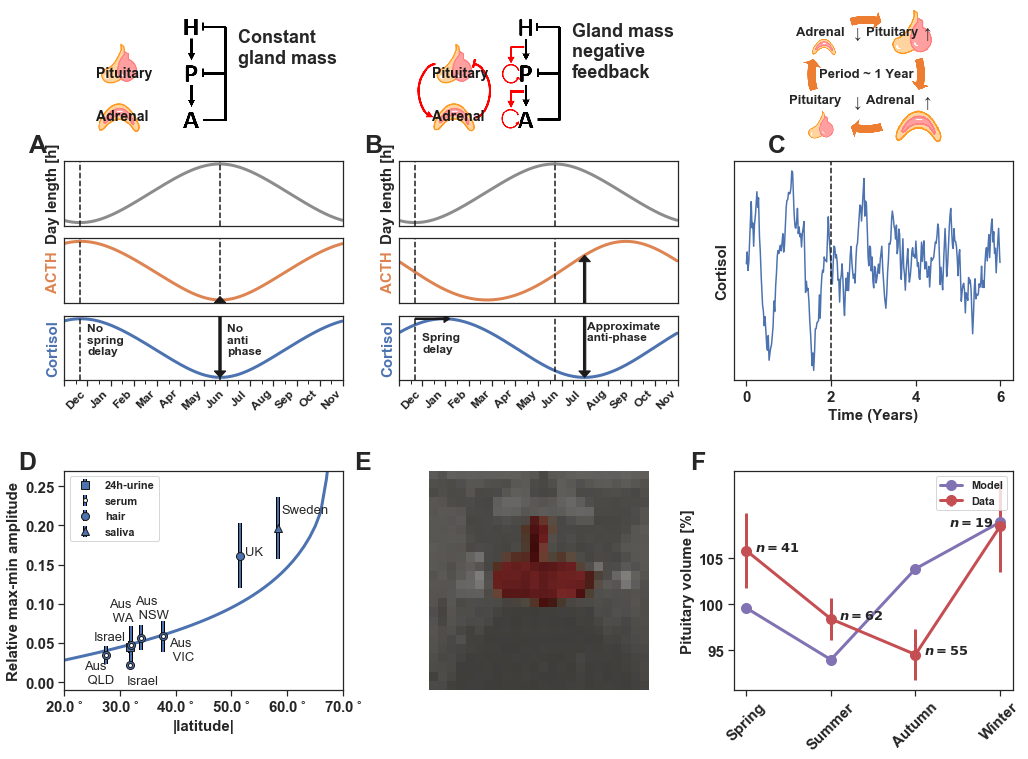

In [21]:
plt.rcParams["font.weight"] = "bold"
####################################################################
####################################################################
'''
FIG 3A -  Code to plot sesonality in a model without slow time scale
'''
####################################################################
####################################################################
fig = plt.figure(figsize=(17,14))
ax0 = plt.subplot2grid((10, 3), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((10, 3), (2, 0))
ax2 = plt.subplot2grid((10, 3), (3, 0))
ax3 = plt.subplot2grid((10, 3), (4, 0))
HPA_graph1_above_axe(ax0)
axes= [ax1,ax2,ax3]

ax0.text(-0.1, 0.1, 'A', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')

sim_time = np.linspace(-21,4*365-1-21,4*365)
K0 = 4,
res= []

for i,t in enumerate(sim_time[:-1]):
    u          = 2 - daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12
    x1,x2,x3   = GetNumericSS_GR(u,1,1,K0,1)
    res.append([x1,x2,x3])
res =np.array(res[-365:])
res = res/np.mean(res,axis=0)
x1  = res[:,0]; x2  = res[:,1]; x3  = res[:,2]
theory_3_subplot(axes,np.arange(365)/365*12,
                 [daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180) for t in sim_time[-365:]],
                 x2,x3,'ACTH','Cortisol',def_color[1],def_color[0])  

arrow_y_head = np.diff(ax2.get_ylim())[0]/10
ax2.arrow(12*x3.argmin()/365, ax2.get_ylim()[0],
          0, 0,
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

arrow_y_head = np.diff(ax3.get_ylim())[0]/10
ax3.arrow(12*x3.argmin()/365, ax3.get_ylim()[1],
          0, -(ax3.get_ylim()[1]-x3.min()-arrow_y_head),
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

ylim      = ax3.get_ylim()
anot_yloc = ylim[0] + np.diff(ylim)[0]*0.4

ax3.annotate('No \nanti \nphase',[7,anot_yloc],fontsize=12)
ax3.annotate('No \nspring \ndelay',[1,anot_yloc],fontsize=12)
ax1.axvline(x=0.7,ls='--',c='k')
ax2.axvline(x=0.7,ls='--',c='k')
ax3.axvline(x=0.7,ls='--',c='k')
ax1.axvline(x=6.7,ls='--',c='k')
ax2.axvline(x=6.7,ls='--',c='k')
ax3.axvline(x=6.7,ls='--',c='k')

ax3.set_xticks(np.arange(0,13,1))
ax3.set_xticklabels([])
ax3.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax3.set_xticklabels(month_names0[::1], rotation=45,fontsize=12,fontweight='bold',minor =True)

####################################################################
####################################################################
'''
FIG 3B -  Code to plot sesonality in a model with tissue turnover
'''
####################################################################
####################################################################
ax0 = plt.subplot2grid((10, 3), (0, 1), rowspan=2)
ax1 = plt.subplot2grid((10, 3), (2, 1))
ax2 = plt.subplot2grid((10, 3), (3, 1))
ax3 = plt.subplot2grid((10, 3), (4, 1))
HPA_graph2_above_axe(ax0)
axes= [ax1,ax2,ax3]

ax0.text(-0.1, 0.1, 'B', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')

sim_time = np.linspace(-21,4*365-1-21,4*365)
adrenal     = np.zeros_like(sim_time)
pituitary   = np.zeros_like(sim_time)
adrenal[0]  = 1; pituitary[0]= 1; K0 = 4
aP=slow_rate; aA=slow_rate; bP=slow_rate; bA=slow_rate
aP=slow_rate; aA=slow_rate; bP=slow_rate; bA=slow_rate

for i,t in enumerate(sim_time[:-1]): 
    A = adrenal[i]; P = pituitary[i]
    u          = 2 - daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180)/12
    x1,x2,x3   = GetNumericSS_GR(u,A,P,K0,1)
    dA = A*(bA*x2-aA) #Adrenal cells
    dP = P*(bP*x1-aP) #Pituitary cells
    adrenal[i+1]   = A + dA
    pituitary[i+1] = P + dP
    
adrenal   = adrenal[-365:] ; pituitary = pituitary[-365:]

res = np.array([GetNumericSS_GR(1,A,P,K0,1) for A,P in zip(adrenal,pituitary)])
res = res/np.mean(res,axis=0)
x1  = res[:,0]; x2  = res[:,1]; x3  = res[:,2]
theory_3_subplot(axes,np.arange(365)/365*12,
                 [daylen(31.77,delta=23.44*np.cos(2*np.pi*((t)/365))*np.pi/180) for t in sim_time[-365:]],
                 x2,x3,'ACTH','Cortisol',def_color[1],def_color[0]) 

arrow_y_head = np.diff(ax2.get_ylim())[0]/10
ax2.arrow(12*x3.argmin()/365, ax2.get_ylim()[0]-arrow_y_head,
          0, x2[x3.argmin()]-ax2.get_ylim()[0],
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

arrow_y_head = np.diff(ax3.get_ylim())[0]/10
ax3.arrow(12*x3.argmin()/365, ax3.get_ylim()[1],
          0, -(ax3.get_ylim()[1]-x3.min()-arrow_y_head),
          width=0.1, head_width=0.5, head_length=arrow_y_head, fc='k', ec='k', zorder=4)

ylim      = ax3.get_ylim()
anot_yloc = ylim[0] + np.diff(ylim)[0]*0.44
ax3.annotate('Approximate \nanti-phase \n ',[8.1,anot_yloc],fontsize=12)
ax3.annotate('\nSpring \ndelay',[1,anot_yloc],fontsize=12)
ax3.arrow(0.7, x3.max(), 12*x3.argmax()/365-0.7, 0,width=0.005, head_width=0.025, head_length=0.25, fc='k', ec='k', zorder=4)
ax1.axvline(x=0.7,ls='--',c='k'); ax1.axvline(x=6.7,ls='--',c='k')
ax2.axvline(x=0.7,ls='--',c='k'); ax2.axvline(x=6.7,ls='--',c='k')
ax3.axvline(x=0.7,ls='--',c='k'); ax3.axvline(x=6.7,ls='--',c='k')

ax3.set_xticks(np.arange(0,13,1))
ax3.set_xticklabels([])
ax3.set_xticks(np.arange(0,12,1)+0.5,minor=True)
ax3.set_xticklabels(month_names0[::1], rotation=45,fontsize=12,fontweight='bold',minor =True)
##########################################################
##########################################################
'''
FIG 3C -  Code to plot circannual oscilator image
'''
##########################################################
##########################################################
img = plt.imread('../figures/ppt/HPA_oscilator.PNG')       
ax = plt.subplot2grid((10, 3), (0, 2), rowspan=2)
ax.text(-0.1, 0.1, 'C', transform=ax.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax.imshow(img)
ax.axis('off')

# ax = plt.subplot2grid((10, 3), (2, 2), rowspan=3)
# ax.axis('off')
an_shift=0.15
ax.annotate('Pituitary',fontsize=13,fontweight='bold',
            xytext=(0.07-an_shift,0.32),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('↓',fontsize=15,fontweight='bold',
            xytext=(0.37,0.30),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Pituitary',fontsize=13,fontweight='bold',
            xytext=(0.6-an_shift,0.8),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('↑',fontsize=15,fontweight='bold',
            xytext=(0.85,0.78),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Adrenal',fontsize=13,fontweight='bold',
            xytext=(0.6-an_shift,0.32),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('↑',fontsize=15,fontweight='bold',
            xytext=(0.85,0.30),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Adrenal',fontsize=13,fontweight='bold',
            xytext=(0.12-an_shift,0.8),xy=(0,0),
            
            xycoords='axes fraction',textcoords='axes fraction')
ax.annotate('↓',fontsize=15,fontweight='bold',
            xytext=(0.37,0.78),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax.annotate('Period ~ 1 Year',fontsize=13,fontweight='bold',
            xytext=(0.275-an_shift,0.5),xy=(0,0),
            xycoords='axes fraction',textcoords='axes fraction')

ax = plt.subplot2grid((10, 3), (2, 2), rowspan=3)
ax.plot(np.arange(len(x3_noise[3]))/365,x3_noise[3],c=def_color[0])
ax.set_xlabel('Time (Years)',fontsize=15,fontweight='bold')
ax.set_ylabel('Cortisol',fontsize=15,fontweight='bold')
ax.tick_params(axis='x',labelsize =15)
ax.set_yticks([])    
ax.axvline(2,ls='--',color='k')
##########################################################
##########################################################
'''
FIG 3E -  Code to show pituitary segmentation image 
'''
##########################################################
##########################################################
imgs  = '../data/HCP_imgs/Images/'
masks = '../data/HCP_imgs/Predictions/'
ids   = [img_name[:-2] for img_name in os.listdir(imgs)]
img   = pickle.load(open(imgs+ids[19] +'.p','rb'))['ROI'][:,:,5]
mask  = np.rot90(sio.loadmat(masks +ids[19] +'.mat')['mask'].T,-1)[:,:,5]
ax0   = plt.subplot2grid((10, 3), (5, 1), rowspan=1)
ax0.text(-0.1, 0.1, 'E', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')
mask2 = mask*img
im = np.dstack((mask2,np.zeros_like(mask2),np.zeros_like(mask2)))
ax = plt.subplot2grid((10, 3), (6, 1), rowspan=3)
ax.imshow(img, cmap='gray')
ax.imshow(mask,alpha=0.5,cmap ='OrRd')
ax.imshow(im,alpha=0.5,cmap ='OrRd')
ax.axis('off')
##########################################################
##########################################################
'''
FIG 3F -  Code to plot pituitary seasonality
'''
##########################################################
##########################################################
ax0 = plt.subplot2grid((10, 3), (5, 2), rowspan=1)
ax0.text(-0.1, 0.1, 'F', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')
ax = plt.subplot2grid((10, 3), (6, 2), rowspan=3)
pituitary_df = pickle.load(open('../data/HCP_df_0706.p','rb'))
pituitary_df['norm_pituitary'] = pituitary_df['norm_pituitary']/np.mean(pituitary_df['norm_pituitary'])
pituitary_df

season_mean = 100*np.array([pituitary_df.loc[pituitary_df['Season'] == s,['norm_pituitary']].mean().values[0] for s in seasons])
season_std  = 100*np.array([pituitary_df.loc[pituitary_df['Season'] == s,['norm_pituitary']].std().values[0] for s in seasons])
season_n    = [len(pituitary_df.loc[pituitary_df['Season'] == s,['norm_pituitary']]) for s in seasons]
season_err  = season_std/np.sqrt(season_n)

ax.errorbar([0,1,2,3],season_mean,yerr=season_err,marker='.',color=def_color[3],markersize=20,linewidth=3)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(seasons, rotation=45)

ax.set_yticks([95,100,105]); anot_shift = [0.1,0.1,0.1,-0.6];
ax.set_ylabel('Pituitary volume [%]',fontsize=15,fontweight='bold')
[ax.annotate('$n=' + str(len(pituitary_df.loc[pituitary_df.Season== s])) +'$',(i+anot_shift[i],season_mean[i]),fontsize=13,fontweight='bold') for i,s in enumerate(seasons)]

winter_pit = np.mean(pituitary[0:91])
spring_pit = np.mean(pituitary[91:182])
summer_pit = np.mean(pituitary[182:273])
fall_pit   = np.mean(pituitary[273:])

season_pit = 100*np.array([spring_pit,summer_pit,fall_pit,winter_pit])
ax.plot([0,1,2,3],season_pit,marker='.',color=def_color[4],markersize=20,linewidth=3)
ax.legend(['Model','Data'])
ax.tick_params(axis='y',labelsize =15)
ax.tick_params(axis='x',labelsize =15)
##########################################################
##########################################################
'''
FIG 3D -  Code to plot amplitude/lattitude plot
'''
##########################################################
##########################################################
ax0 = plt.subplot2grid((10, 3), (5, 0), rowspan=1)
ax0.text(-0.1, 0.1, 'D', transform=ax0.transAxes,fontsize = 25, fontweight='bold', va='top', ha='right')
ax0.axis('off')
ax = plt.subplot2grid((10, 3), (6, 0), rowspan=3)
plot_latitudes(ax)

[PHIs,amp_res] = pickle.load(open('../data/Theoretical_amplitude_latitude.pickle','rb'))
ax.plot(PHIs,np.array(amp_res),lw=3,c=def_color[0],zorder=-1)
##########################################################
##########################################################
# plt.tight_layout()
plt.subplots_adjust(hspace=0.2,wspace=0.2)
# plt.savefig('../figures/Seasonality160620/Figure4.pdf',bbox_inches='tight',dpi=600)
plt.show()

######### 2-WAY ANOVA #########


,Source,SS,DF,MS,F,p-unc,np2
0,Gender,1.121,1.0,1.121,32.139,5.990992e-08,0.158
1,Age_group,0.237,2.0,0.119,3.402,3.557514e-02,0.038
2,Gender * Age_group,0.080,2.0,0.040,1.152,3.183194e-01,0.013
3,Residual,5.966,171.0,0.035,NaN,NaN,NaN


mean vol    0.068168
dtype: float64

######### Linear Regression #########


mean vol    0.049814
dtype: float64

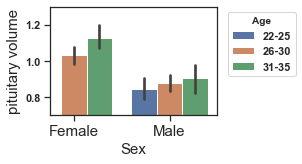

In [22]:
def anova_2way_pituitary_seasonality(measure_type = 'norm_pituitary'):
    raw_df = pickle.load(open('../data/HCP_df_0706.p','rb'))
    raw_df['norm_pituitary'] = raw_df['norm_pituitary']/raw_df['norm_pituitary'].mean()
    df = raw_df.copy()
    
    print('######### 2-WAY ANOVA #########')
    aov= pg.anova(dv=measure_type, between=['Gender','Age_group'], data=df)
    display(aov)
    
    season_df = pd.DataFrame([df.loc[df['Season']   ==m,[measure_type]].mean().values[0] for m in seasons]  ,index=seasons,columns = ['mean vol'])
    display((season_df.max() - season_df.min())/(2*season_df.mean()))
    
    print('######### Linear Regression #########')
    rdf = df[['ID','sex','Age_group',measure_type]].copy()
#     rdf['interaction'] = rdf['sex']*rdf['Age_group']
    x   = np.array(rdf[['sex','Age_group']])#,'interaction']])
    y   = rdf[measure_type].values
    reg_model = LinearRegression().fit(x,y)
    rdf['reg_pit'] = (y-reg_model.predict(x)) + reg_model.intercept_
    df['reg_pit']  = rdf['reg_pit']
    season_df_reg = pd.DataFrame([df.loc[df['Season']   ==m,['reg_pit']].mean().values[0] for m in seasons]  ,index=seasons,columns = ['mean vol'])
    display((season_df_reg.max() - season_df_reg.min())/(2*season_df_reg.mean()))
    return df

df = anova_2way_pituitary_seasonality()
plt.figure(figsize=(3,2))
df = df.loc[~((df.sex==0) & (df.Age_group == 0))]
ax= sns.barplot(x="sex", y="norm_pituitary", hue="Age_group", data=df) 
ax.set_xlim([-0.25,1.5])
ax.set_ylim([0.7,1.3])
ax.set_xticklabels(['Female','Male'],fontsize=15,fontweight='normal')
ax.set_xlabel('Sex',fontsize=15)
ax.set_ylabel('pituitary volume',fontsize=15);
l = ax.legend(loc='upper right',title="Age",bbox_to_anchor=(1.5, 1))
l.get_texts()[0].set_text('22-25')
l.get_texts()[1].set_text('26-30')
l.get_texts()[2].set_text('31-35')

# plt.savefig('../figures/Seasonality160620/Pituitary_ANOVA.pdf',bbox_inches='tight',dpi=600)